In [19]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model import *
from utils import *

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = "ACM_DBLP" # args.dataset
device = torch.device('cuda:3' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
    train_set = ["ACM", "DBLP"]
    input_dim = 17
    b = np.load('data/ACM-DBLP.npz')
    train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
    train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
    test_pairs = b['test_pairs'].astype(np.int32)
    NUM_HIDDEN_LAYERS = 12
    HIDDEN_DIM = 1024
    output_feature_size = 1024
    lr = 0.0001
    epoch = 50
elif (data == "Douban Online_Offline"):
    a1, f1, a2, f2, test_pairs = load_douban()
    f1 = f1.A
    f2 = f2.A
    train_set = ["Online", "Offline"]
    input_dim = 538
    test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
    test_pairs = test_pairs.numpy()
    train_features["Online"] = [torch.from_numpy(f1).float()]
    train_features["Offline"] = [torch.from_numpy(f2).float()]
    NUM_HIDDEN_LAYERS = 6
    HIDDEN_DIM = 512
    output_feature_size = 512
    lr = 0.0001
    epoch = 100


In [4]:
temp = torch.from_numpy(b["x1"]).float() # G1, node attributes
# temp = torch.from_numpy(f1).float()
print(temp.shape)
temp

torch.Size([9872, 17])


tensor([[61., 42., 16.,  ..., 14.,  1., 22.],
        [54., 18., 12.,  ..., 11.,  0., 16.],
        [54., 61.,  9.,  ..., 10.,  0., 39.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.]])

In [5]:
temp = torch.from_numpy(b["x2"]).float() # G2, node attributes
# temp = torch.from_numpy(f2).float()
print(temp.shape)
temp

torch.Size([9916, 17])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 4., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [ ]:
""" temp = b["test_pairs"]
print(temp.shape)
temp """

In [ ]:
test_pairs

In [ ]:
train_set

In [6]:
encoder = "GIN"
use_input_augmentation = True
use_output_augmentation = False
print("Loading training datasets")
train_loader = {}
for dataset in train_set:
    train_loader[dataset] = [load_adj(dataset)]

train_loader

Loading training datasets


{'ACM': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])],
 'DBLP': [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])]}

In [ ]:
train_loader.keys()

In [7]:
temp = train_loader[train_set[0]][0]
print(temp.shape)
temp

torch.Size([9872, 9872])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
temp = train_loader[train_set[1]][0]
print(temp.shape)
temp

torch.Size([9916, 9916])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
model = GAE(NUM_HIDDEN_LAYERS,
            input_dim,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=use_input_augmentation,
            use_output_augmentation=use_output_augmentation,
            encoder=encoder).to(device)
model

GAE(
  (base_gcn): GIN(
    (in_proj): Linear(in_features=17, out_features=1024, bias=True)
    (convs): ModuleList(
      (0-13): 14 x GINConv(
        (linear): Linear(in_features=1041, out_features=1024, bias=True)
      )
    )
    (out_proj): Linear(in_features=15360, out_features=1024, bias=True)
  )
)

In [10]:
print("Generating training features")


Generating training features


In [11]:
print("Fitting model")
# fit_GAE_real(data, len(train_set) * (1 + 1), model, epoch, train_loader, train_features, device, lr,test_pairs)
# fit_GAE_real(data, no_samples, GAE, epoch, train_loader, train_features, device, lr, test_pairs):

no_samples = len(train_set) * (1 + 1)
GAE = model
# ---

best_hitAtOne = 0
best_hitAtFive = 0
best_hitAtTen = 0
best_hitAtFifty = 0
optimizer = Adam(GAE.parameters(), lr=lr, weight_decay=5e-4)

for step in tqdm(range(epoch)):
    loss = 0
    
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z,z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()

    # Adjacency matrix
    keys = list(train_loader.keys())
    S1 = train_loader[keys[0]][0]
    S2 = train_loader[keys[1]][0]
    
    adj_S1 = coo_matrix(S1.numpy())
    adj_norm_1 = preprocess_graph(adj_S1)
    adj_norm_1 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_1[0].T),
                                            torch.FloatTensor(adj_norm_1[1]),
                                            torch.Size(adj_norm_1[2])).to(device)
    adj_S2 = coo_matrix(S2.numpy())
    adj_norm_2 = preprocess_graph(adj_S2)
    adj_norm_2 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_2[0].T),
                                            torch.FloatTensor(adj_norm_2[1]),
                                            torch.Size(adj_norm_2[2])).to(device)
    if (data == "ACM_DBLP"):
        S1_feat = train_features["ACM"][0]
        S2_feat = train_features["DBLP"][0]
    elif (data == "Douban Online_Offline"):
        S1_feat = train_features["Online"][0]
        S2_feat = train_features["Offline"][0]

    # get node embeddings
    S1_emb = GAE(S1_feat.to(device), adj_norm_1).detach()
    S2_emb = GAE(S2_feat.to(device), adj_norm_2).detach()

    D = torch.cdist(S1_emb, S2_emb, 2) # Euclidean distance
    
    # test
    
    
    """ if (data == "ACM_DBLP"):
        test_idx = test_pairs[:, 0].astype(np.int32)
        labels = test_pairs[:, 1].astype(np.int32)
    elif (data == "Douban Online_Offline"):
        test_idx = test_pairs[0, :].astype(np.int32)
        labels = test_pairs[1, :].astype(np.int32)
    
    hitAtOne = 0
    hitAtFive = 0
    hitAtTen = 0
    hitAtFifty = 0
    hitAtHundred = 0
        
    for i in range(len(test_idx)): # here
        dist_list = D[test_idx[i]]
        # print(i, test_idx[i], dist_list)
        sorted_neighbors = torch.argsort(dist_list).cpu()
        label = labels[i]
        
        # if i == 0:
        #    print(label, sorted_neighbors[0].item(), sorted_neighbors)
        #    # 6829 6829 tensor([6829, 3102,  601,  ..., 7878, 9701, 2044])
        
        for j in range(100):
            if (sorted_neighbors[j].item() == label):
                if (j == 0):
                    hitAtOne += 1
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 4):
                    hitAtFive += 1
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 9):
                    hitAtTen += 1
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 49):
                    hitAtFifty += 1
                    hitAtHundred += 1
                    break
                elif (j <= 100):
                    hitAtHundred += 1
                    break
    
    cur_hitAtOne = hitAtOne / len(test_idx)
    cur_hitAtFive = hitAtFive / len(test_idx)
    cur_hitAtTen = hitAtTen / len(test_idx)
    cur_hitAtFifty = hitAtFifty / len(test_idx)

    if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
    if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
    if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
    if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty """

print("The best results achieved:")
print("Hit@1: ", end="")
print(best_hitAtOne)
print("Hit@5: ", end="")
print(best_hitAtFive)
print("Hit@10: ", end="")
print(best_hitAtTen)
print("Hit@50: ", end="")
print(best_hitAtFifty)

Fitting model


100%|██████████| 50/50 [02:19<00:00,  2.78s/it]

The best results achieved:
Hit@1: 0
Hit@5: 0
Hit@10: 0
Hit@50: 0


In [ ]:
# D = D[:1118,:]
print(D.shape)
D

In [ ]:
def hungarian(D):
    print("0")
    P = torch.zeros_like(D)
    matrix = D.tolist()
    m = Munkres()
    print("1")
    indexes = m.compute(matrix)
    print("2")
    total = 0
    for r, c in tqdm(indexes):
        print(r)
        P[r][c] = 1
        total += matrix[r][c]
    return P.t()

# P = hungarian(D)

In [ ]:
# save

# X = P.cpu().numpy()
# np.save("P_hungarian", X)

In [ ]:
# load

P = np.load("P_hungarian.npy")
P

Ground truth

In [16]:
test_idx = test_pairs[:, 0].astype(np.int32)
labels = test_pairs[:, 1].astype(np.int32)

print(test_pairs)
print("test_idx", test_idx, np.sort(test_idx), len(test_idx))
print("labels", labels, np.sort(labels), len(labels)) # 0, 1, 2, ...

[[   0 6829]
 [   2 3102]
 [   3 3584]
 ...
 [9841 3392]
 [9850  306]
 [9868 9011]]
test_idx [   0    2    3 ... 9841 9850 9868] [   0    2    3 ... 9841 9850 9868] 5060
labels [6829 3102 3584 ... 3392  306 9011] [   1    2    3 ... 9907 9911 9915] 5060


In [ ]:
test_idx = test_pairs[0, :].astype(np.int32)
labels = test_pairs[1, :].astype(np.int32)

print(test_pairs)
print("test_idx", test_idx, np.sort(test_idx))
print("labels", labels, np.sort(labels)) # 0, 1, 2, ...

In [17]:
temp = test_pairs

print(temp.shape)
print(test_pairs)
print(temp)

ground_truth = np.array(temp[temp[:, 1].argsort()].tolist())
print("Ground truth")
ground_truth

(5060, 2)
[[   0 6829]
 [   2 3102]
 [   3 3584]
 ...
 [9841 3392]
 [9850  306]
 [9868 9011]]
[[   0 6829]
 [   2 3102]
 [   3 3584]
 ...
 [9841 3392]
 [9850  306]
 [9868 9011]]
Ground truth


array([[3615,    1],
       [1302,    2],
       [ 466,    3],
       ...,
       [6148, 9907],
       [3826, 9911],
       [7275, 9915]])

Option 1: Hungarian (source code)

In [ ]:
print(P.shape)
print(P)

plt.matshow(P.T, cmap='Blues')
plt.show()

In [ ]:
# from Hungarian (source code)
P_option1 = []
m, n = P.shape
for i in range(m):
    for j in range(n):
        if P[i][j] == 1:
            P_option1.append([j, i]) # S, S_hat
P_option1 = np.array(P_option1)
print(len(P_option1))
P_option1

Option 2: hungarian_algorithm

Total Cost: 4595.1181640625
Assignments: [(0, 6829), (1, 601), (2, 3102), (3, 3584), (4, 3744), (5, 685), (6, 1048), (7, 1635), (8, 822), (9, 8863), (10, 8701), (11, 1082), (12, 5697), (13, 2840), (14, 7180), (15, 5900), (16, 339), (17, 8673), (18, 3535), (19, 8217), (20, 660), (21, 9388), (22, 566), (23, 8693), (24, 3856), (25, 699), (26, 2378), (27, 4370), (28, 9870), (29, 1972), (30, 379), (31, 7354), (32, 3738), (33, 6979), (34, 4184), (35, 1387), (36, 5405), (37, 7454), (38, 8989), (39, 4778), (40, 9570), (41, 2559), (42, 1402), (43, 7479), (44, 5569), (45, 9092), (46, 9320), (47, 1710), (48, 7011), (49, 1431), (50, 2686), (51, 3938), (52, 8330), (53, 8846), (54, 9501), (55, 4338), (56, 1626), (57, 4897), (58, 4145), (59, 2098), (60, 3884), (61, 6289), (62, 7689), (63, 8951), (64, 9341), (65, 8458), (66, 966), (67, 6153), (68, 1498), (69, 3172), (70, 4856), (71, 5723), (72, 5611), (73, 7650), (74, 1711), (75, 5088), (76, 7597), (77, 1337), (78, 8714), (79, 5054), (80, 8999), (81, 

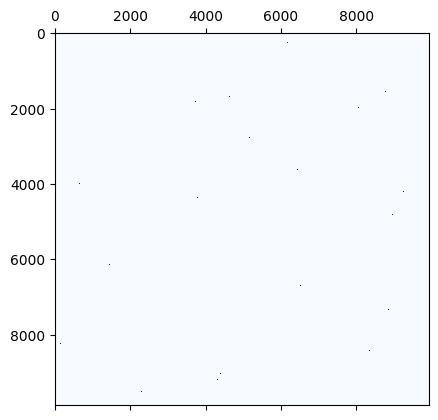

In [20]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_algorithm(cost_matrix):
    # Use the linear_sum_assignment method from scipy
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Total cost
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    # The assignments are returned as (row, col) pairs
    assignments = list(zip(row_ind, col_ind))
    
    return total_cost, assignments

total_cost, assignments = hungarian_algorithm(D.cpu().numpy())

print(f"Total Cost: {total_cost}")
print(f"Assignments: {assignments}")

assignments_ = np.array(assignments)
print(assignments_.shape)
print(assignments_)

m, n = D.shape
matrix = np.zeros((m, n))

for i in range(min(m, n)):
    matrix[assignments_[i][0]][assignments_[i][1]] = 1

print(matrix)
plt.matshow(matrix, cmap='Blues')
plt.show()

In [21]:
P_option2 = assignments_[assignments_[:, 1].argsort()]
print(len(P_option2))
P_option2

9872


array([[4172,    0],
       [3615,    1],
       [1637,    2],
       ...,
       [2873, 9913],
       [9476, 9914],
       [7275, 9915]])

Option 3

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


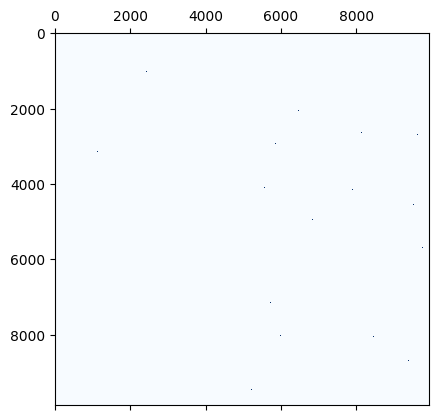

In [29]:
import pygmtools as pygm
import matplotlib.pyplot as plt

X = pygm.hungarian(D.cpu().numpy())
print(X)

plt.matshow(X, cmap='Blues')
plt.show()

In [30]:
P_option3 = []
m, n = X.shape
print(m, n)
for i in range(m):
    for j in range(n):
        if X[i][j] == 1:
            P_option3.append([i, j]) # S, S_hat
P_option3 = np.array(P_option3)
P_option3 = P_option3[P_option3[:, 1].argsort()]
print(len(P_option3))
P_option3

9872 9916
9872


array([[6174,    0],
       [3706,    1],
       [4934,    2],
       ...,
       [9464, 9913],
       [1913, 9914],
       [2874, 9915]])

Option 4

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


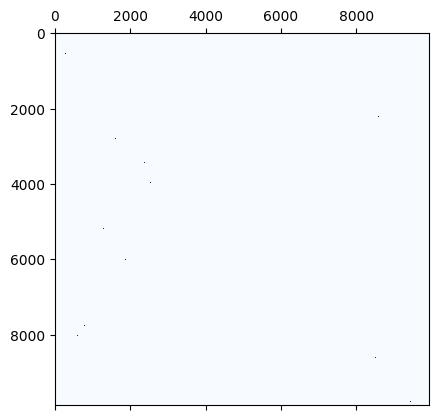

In [31]:
X = greedy_match(D)
X = X.todense()
print(X)

plt.matshow(X, cmap='Blues')
plt.show()

In [32]:
P_option4 = []
m, n = X.shape
print(m, n)
for i in range(m):
    for j in range(n):
        if X[i, j] == 1:
            P_option4.append([i, j]) # S, S_hat
P_option4 = np.array(P_option4)
P_option4 = P_option4[P_option4[:, 1].argsort()]
print(len(P_option4))
P_option4

9872 9916
9872


array([[8144,    0],
       [7985,    1],
       [8029,    2],
       ...,
       [1503, 9913],
       [1547, 9914],
       [8100, 9915]])

Option 5

In [ ]:
print(D.shape)
D

In [33]:
matrix_match = []

for i in range(D.shape[1]):
    dist_list = D[i]
    sorted_neighbors = torch.argsort(dist_list).cpu()
    matrix_match.append([sorted_neighbors[0].item(), i])

P_option5 = np.array(matrix_match)
print(len(P_option5))
P_option5

IndexError: index 9872 is out of bounds for dimension 0 with size 9872

### Comparison

In [23]:
ground_truth

array([[3615,    1],
       [1302,    2],
       [ 466,    3],
       ...,
       [6148, 9907],
       [3826, 9911],
       [7275, 9915]])

In [24]:
P_option2

array([[4172,    0],
       [3615,    1],
       [1637,    2],
       ...,
       [2873, 9913],
       [9476, 9914],
       [7275, 9915]])

In [37]:
ground_truth

array([[3615,    1],
       [1302,    2],
       [ 466,    3],
       ...,
       [6148, 9907],
       [3826, 9911],
       [7275, 9915]])

In [38]:
P_option2

array([[4172,    0],
       [3615,    1],
       [1637,    2],
       ...,
       [2873, 9913],
       [9476, 9914],
       [7275, 9915]])

In [43]:
P_option3

array([[6174,    0],
       [3706,    1],
       [4934,    2],
       ...,
       [9464, 9913],
       [1913, 9914],
       [2874, 9915]])

In [40]:
P_option4

array([[8144,    0],
       [7985,    1],
       [8029,    2],
       ...,
       [1503, 9913],
       [1547, 9914],
       [8100, 9915]])

In [45]:
ground_truth[0], P_option4[0]

(array([3615,    1]), array([8144,    0]))

In [47]:
result = []
for item in ground_truth:
    if item in P_option4:
        result.append(item.tolist())
        print(item, P_option4)
        break
print(len(result))
result

[3615    1] [[8144    0]
 [7985    1]
 [8029    2]
 ...
 [1503 9913]
 [1547 9914]
 [8100 9915]]
1


[[3615, 1]]

In [25]:
print(len(ground_truth))
# print(len(P_option1))
print(len(P_option2))
# print(len(P_option3))


5060
9872


In [ ]:
P_option1

In [22]:
df_results = pd.DataFrame()
df_results["label"] = ground_truth[:, 1]
df_results["truth"] = ground_truth[:, 0]
# df_results["option1"] = P_option1[:, 0]
df_results["option2"] = P_option2[:, 0]
""" df_results["option3"] = P_option3[:, 0]
df_results["option4"] = P_option4[:, 0]
df_results["option5"] = P_option5[:, 0] """

df_results

ValueError: Length of values (9872) does not match length of index (5060)

In [ ]:
df_results["truth-option1"] = df_results["truth"] == df_results["option1"]
df_results["truth-option2"] = df_results["truth"] == df_results["option2"]
df_results["truth-option3"] = df_results["truth"] == df_results["option3"]
df_results["truth-option4"] = df_results["truth"] == df_results["option4"]
df_results["truth-option5"] = df_results["truth"] == df_results["option5"]
df_results

In [ ]:
df_results.describe()

In [ ]:
df_results["truth-option1"].value_counts()

In [ ]:
df_results["truth-option2"].value_counts()

In [ ]:
df_results["truth-option3"].value_counts()

In [ ]:
df_results["truth-option4"].value_counts()

In [ ]:
df_results["truth-option5"].value_counts()